In [12]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import matplotlib.pyplot as plt
from os.path import exists, join
import pandas as pd
from glob import glob
from shapely import Polygon
from awips.dataaccess import DataAccessLayer
from cartopy.feature import ShapelyFeature
from matplotlib.colors import LogNorm
from scipy.stats import beta, dirichlet
%matplotlib inline

In [2]:
path = "/glade/work/cbecker/ptype_real_time/central_region/hrrr/"
run_date = pd.Timestamp("2023-12-15 00:00")
f_hours = np.arange(0, 19)
run_path = join(path, run_date.strftime("%Y%m%d/%H%M/"))
print(run_path)
hrrr_run_files = sorted(glob(run_path + "*.nc"))

/glade/work/cbecker/ptype_real_time/central_region/hrrr/20231215/0000/


In [3]:
hrrr_runs = []
for run_file in hrrr_run_files:
    hrrr_runs.append(xr.open_dataset(run_file))

In [4]:
hrrr_all = xr.concat(hrrr_runs, dim="time")

In [5]:
region = [hrrr_runs[0]["longitude"].values.min() - 360, hrrr_runs[0]["longitude"].values.max() - 360, 
          hrrr_runs[0]["latitude"].values.min(), hrrr_runs[0]["latitude"].values.max()]
region_envelope = Polygon([(region[0],region[2]),(region[0],region[3]),
                          (region[1],region[3]),(region[1],region[2]),
                          (region[0],region[2])])
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest('maps', envelope=region_envelope)
request.addIdentifier('table', 'mapdata.interstate')
request.addIdentifier('geomField', 'the_geom')
interstates = DataAccessLayer.getGeometryData(request)
print("Using " + str(len(interstates)) + " interstate MultiLineStrings")
interstates_sh = ShapelyFeature([ob.getGeometry() for ob in interstates],ccrs.PlateCarree(),
                            facecolor='none', linestyle="-", edgecolor='blue', lw=0.5)

Using 1600 interstate MultiLineStrings


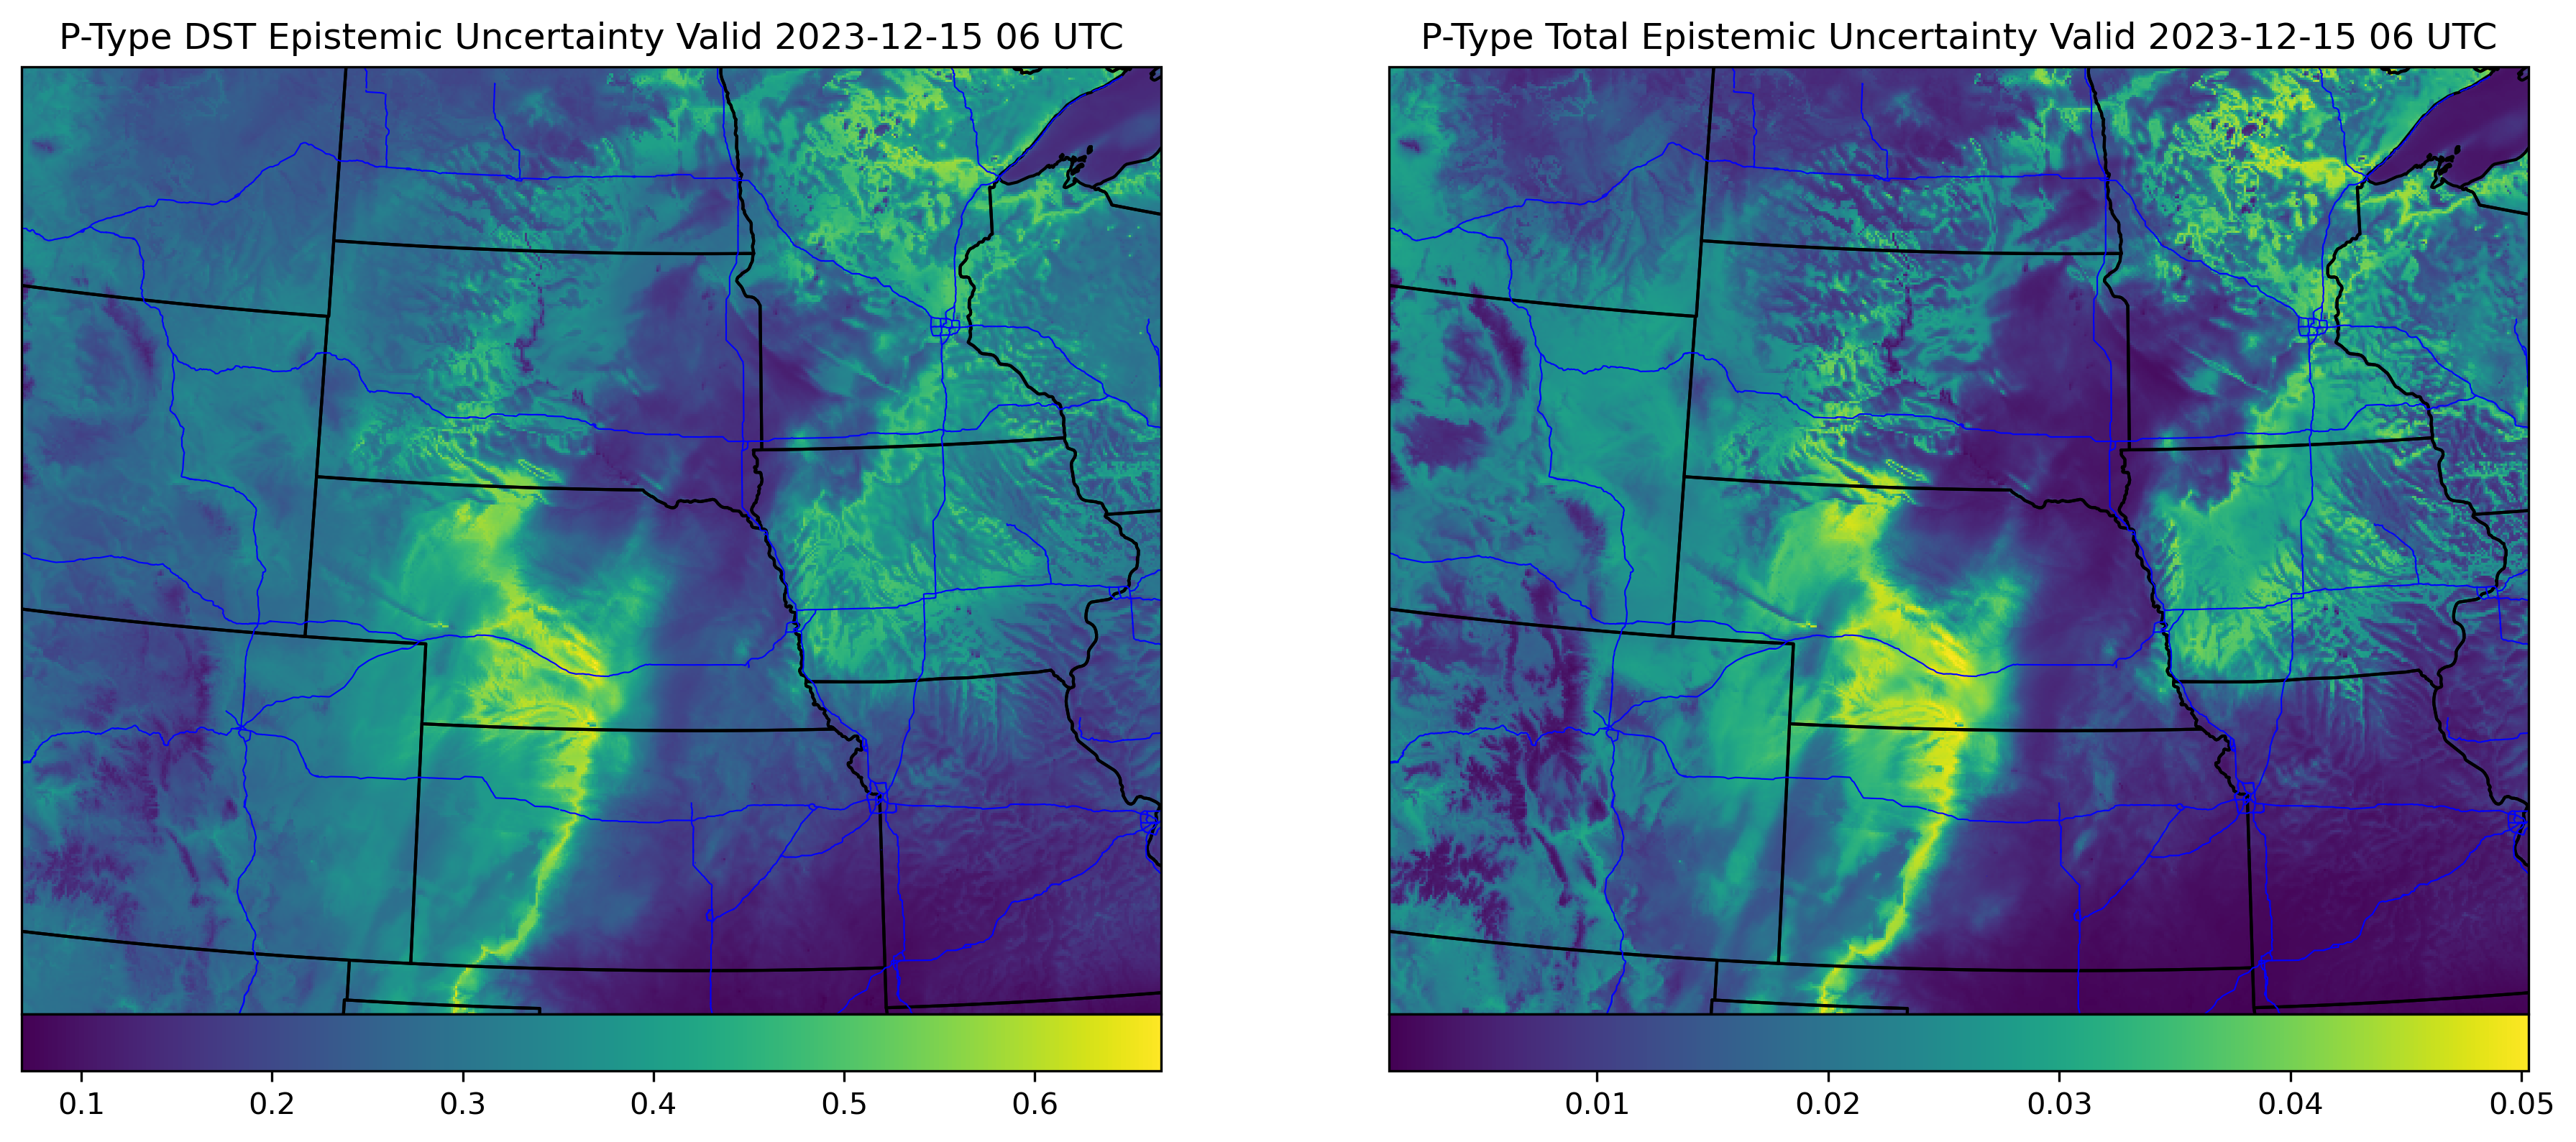

In [6]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5), 
                            globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))
                            
llp = ccrs.PlateCarree()
f = 6
valid_date = run_date + pd.Timedelta(seconds=3600 * f)
valid_date_str = valid_date.strftime('%Y-%m-%d %H UTC')

fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=lcc), dpi=300, figsize=(15, 10))
axes[0].add_feature(cfeature.STATES)
axes[0].add_feature(interstates_sh)
b = axes[0].pcolormesh(hrrr_all["longitude"], hrrr_all["latitude"], hrrr_all["ML_u"][f], transform=llp)
plt.colorbar(b, ax=axes[0], orientation="horizontal", fraction=0.05, pad=0)
axes[0].set_title(f"P-Type DST Epistemic Uncertainty Valid {valid_date_str}")
axes[1].add_feature(cfeature.STATES)
axes[1].add_feature(interstates_sh)
total_epi = np.zeros(hrrr_all["ML_u"][f].shape)
for p in ["rain", "snow", "icep", "frzr"]:
    total_epi += (hrrr_all[f"ML_{p}_epi"][f]) ** 2
total_epi = np.sqrt(total_epi)
b2 = axes[1].pcolormesh(hrrr_all["longitude"], hrrr_all["latitude"], total_epi, transform=llp)
plt.colorbar(b2, ax=axes[1], orientation="horizontal", fraction=0.05, pad=0)
axes[1].set_title(f"P-Type Total Epistemic Uncertainty Valid {valid_date_str}")
plt.savefig("epi_uncertainty_comparison.png", dpi=300, bbox_inches="tight")

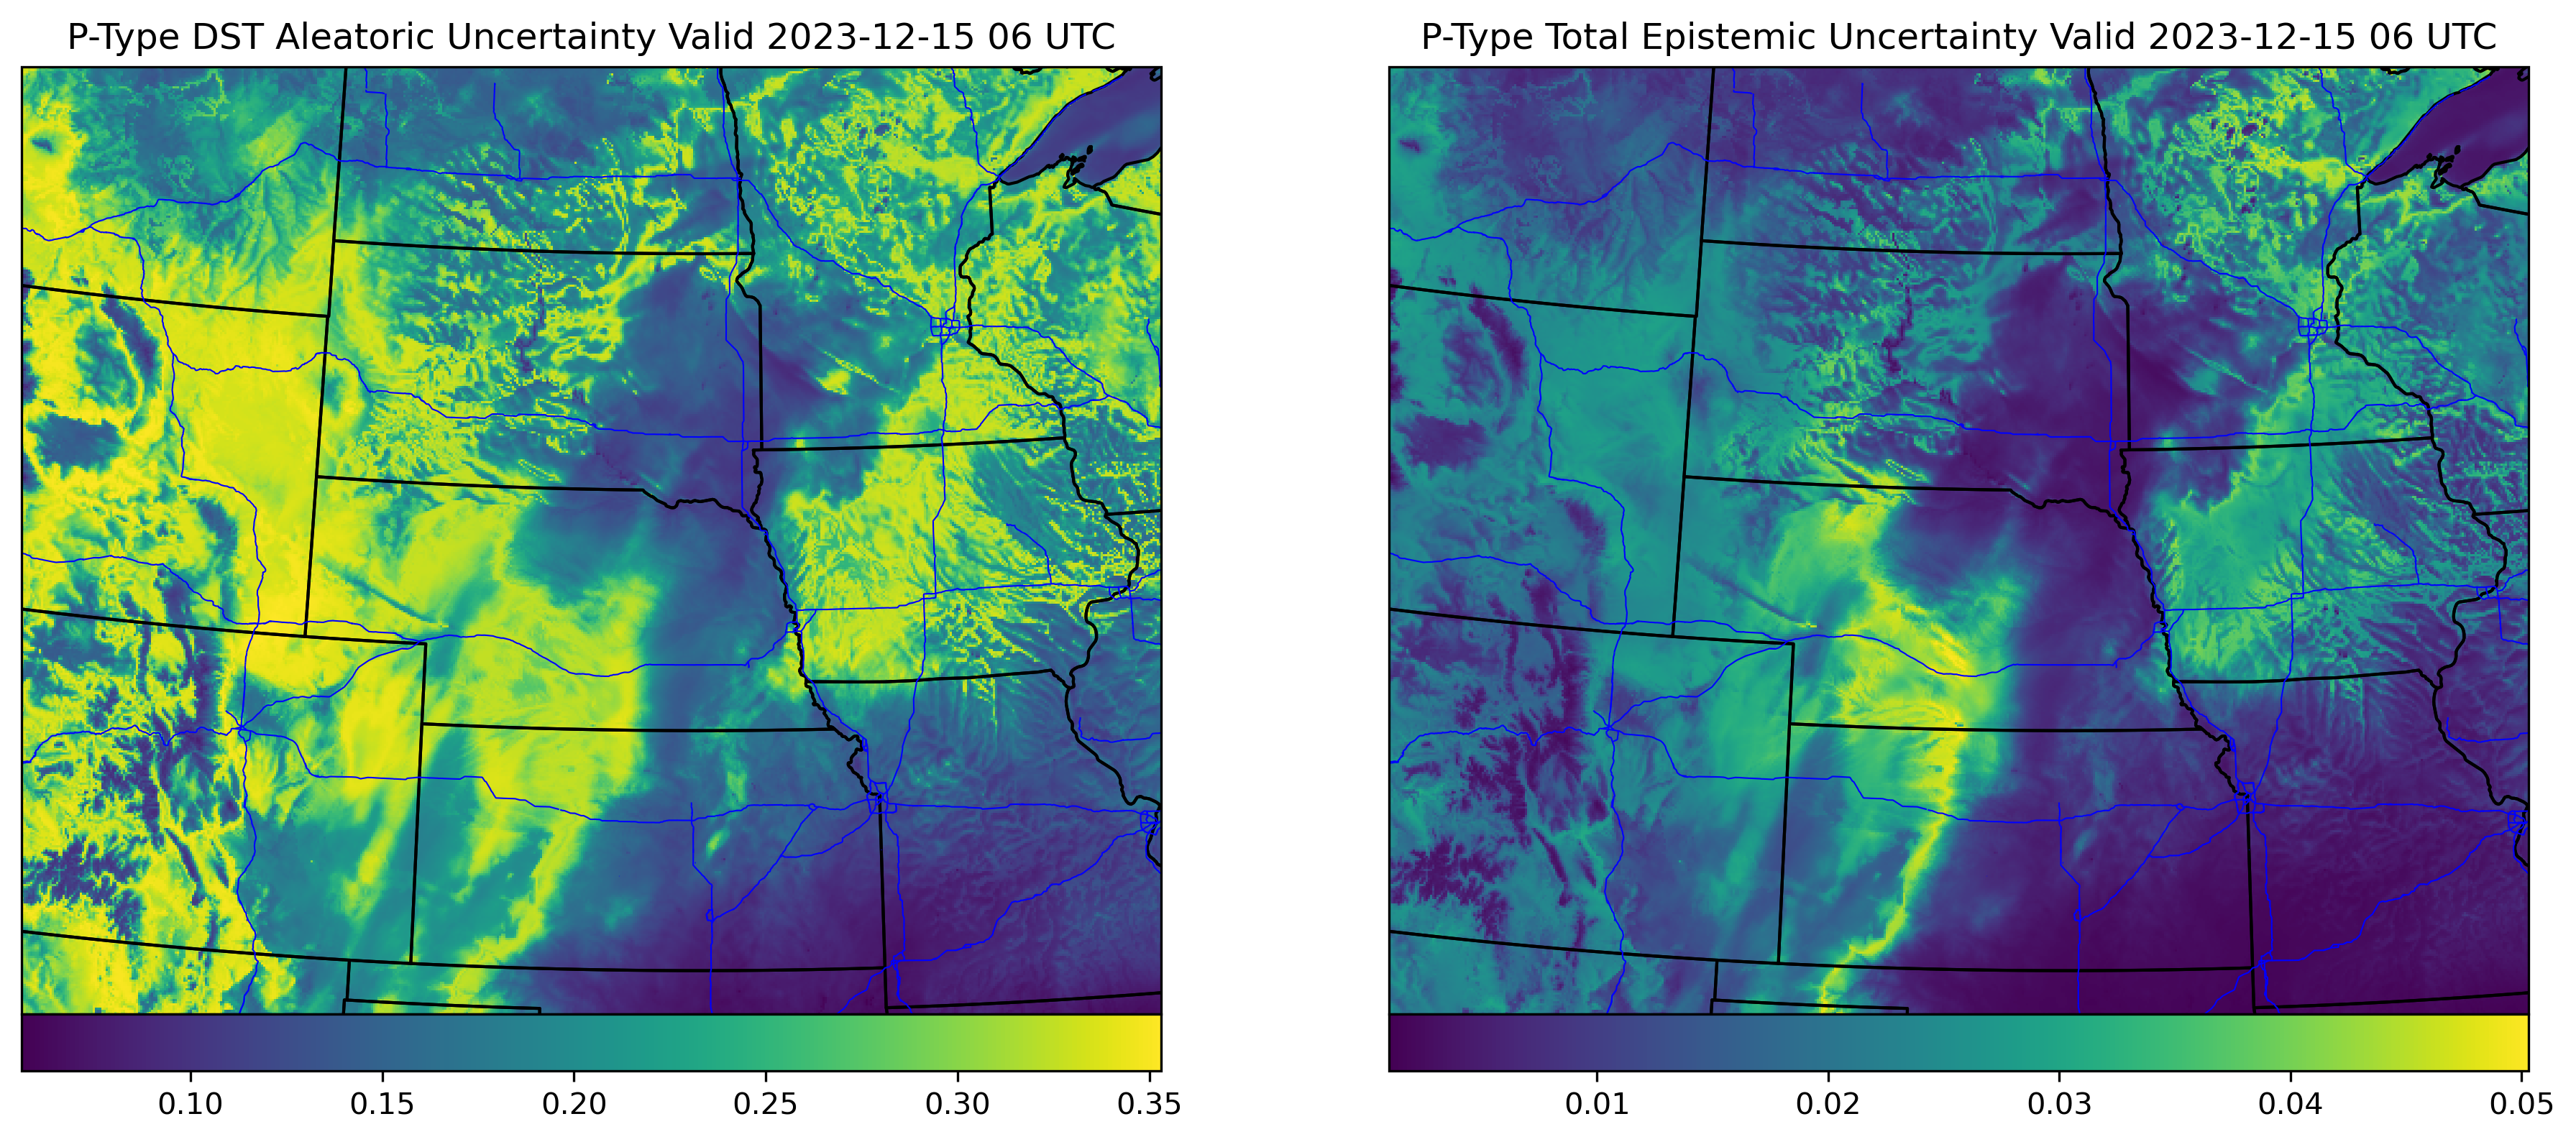

In [7]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5), 
                            globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))
                            
llp = ccrs.PlateCarree()
f = 6
valid_date = run_date + pd.Timedelta(seconds=3600 * f)
valid_date_str = valid_date.strftime('%Y-%m-%d %H UTC')
total_epi = np.zeros(hrrr_all["ML_u"][f].shape)
total_ale = np.zeros(hrrr_all["ML_u"][f].shape)
for p in ["rain", "snow", "icep", "frzr"]:
    total_epi += (hrrr_all[f"ML_{p}_epi"][f]) ** 2
    total_ale += (hrrr_all[f"ML_{p}_ale"][f]) ** 2
total_epi = np.sqrt(total_epi)
total_ale = np.sqrt(total_ale)

fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=lcc), dpi=300, figsize=(15, 10))
axes[0].add_feature(cfeature.STATES)
axes[0].add_feature(interstates_sh)
b = axes[0].pcolormesh(hrrr_all["longitude"], hrrr_all["latitude"], total_ale, transform=llp)
plt.colorbar(b, ax=axes[0], orientation="horizontal", fraction=0.05, pad=0)
axes[0].set_title(f"P-Type DST Aleatoric Uncertainty Valid {valid_date_str}")
axes[1].add_feature(cfeature.STATES)
axes[1].add_feature(interstates_sh)


b2 = axes[1].pcolormesh(hrrr_all["longitude"], hrrr_all["latitude"], total_epi, transform=llp)
plt.colorbar(b2, ax=axes[1], orientation="horizontal", fraction=0.05, pad=0)
axes[1].set_title(f"P-Type Total Epistemic Uncertainty Valid {valid_date_str}")
plt.savefig("ale_epi_comparison.png", dpi=300, bbox_inches="tight")

(array([[1.2637e+04, 2.2430e+04,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan, 4.5960e+03, 3.5674e+04, 1.3630e+03,        nan,
                nan,        nan,        nan,        nan,        nan],
        [       nan, 3.3400e+02, 8.3640e+03, 2.4352e+04, 1.0280e+03,
                nan,        nan,        nan,        nan,        nan],
        [       nan, 1.4000e+01, 5.4890e+03, 1.3001e+04, 1.4873e+04,
         1.8000e+01,        nan,        nan,        nan,        nan],
        [       nan,        nan, 1.5000e+02, 1.8383e+04, 1.1679e+04,
         5.1660e+03,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan, 1.2170e+03, 1.5599e+04,
         7.1710e+03, 1.7520e+03,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan, 1.4000e+02,
         8.4800e+03, 4.8600e+03, 4.7200e+02,        nan,        nan],
        [       nan,       

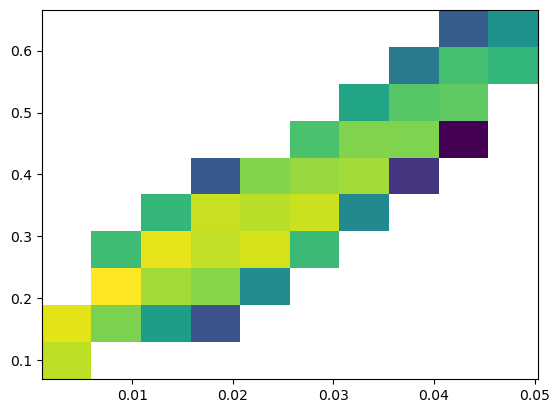

In [13]:
plt.hist2d(total_epi.values.ravel(), hrrr_all["ML_u"][f].values.ravel(), cmin=1, norm=LogNorm())

In [8]:
ptypes = ["rain", "frzr", "icep", "snow"]
precip_mask = np.zeros((len(hrrr_runs), hrrr_runs[0].dims["y"], hrrr_runs[0].dims["x"]))
for i in range(len(hrrr_runs)):
    for ptype in ptypes:
        precip_mask[i][hrrr_all[f"c{ptype}"][i] > 0] = 1
 

/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


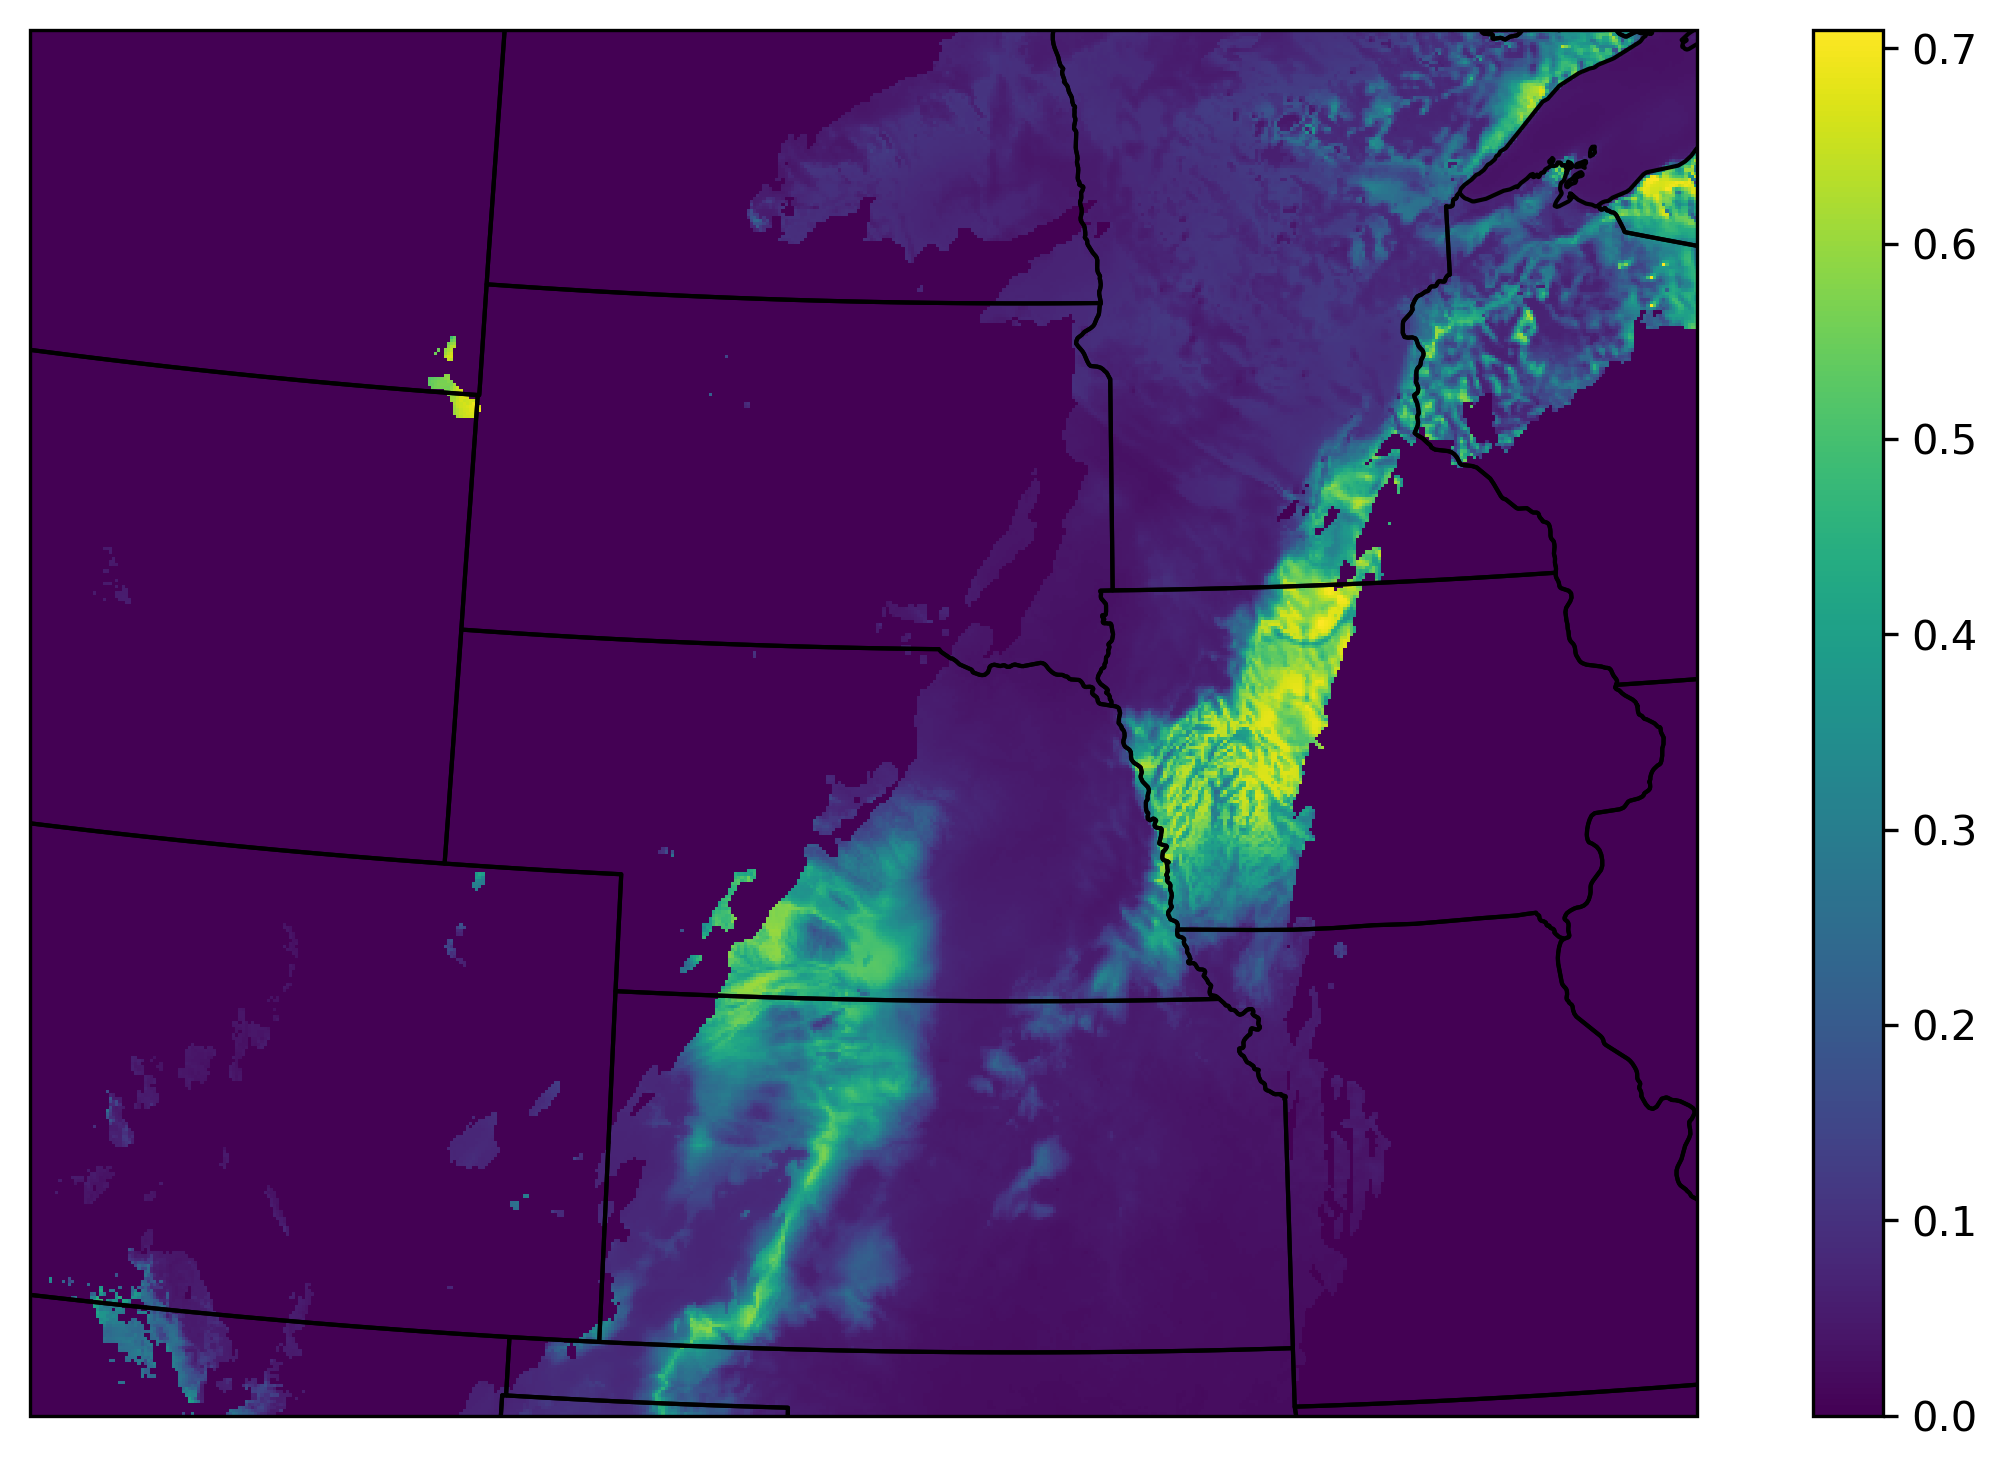

In [9]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5), 
                            globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))                            
llp = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=lcc), dpi=300, figsize=(10, 6))
ax.add_feature(cfeature.STATES)
f = 5
plt.pcolormesh(hrrr_runs[f]["longitude"], hrrr_runs[f]["latitude"], hrrr_runs[f]["ML_icep"][0] * precip_mask.max(axis=0), transform=llp)
plt.colorbar()

rain
frzr


/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


icep
snow


/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


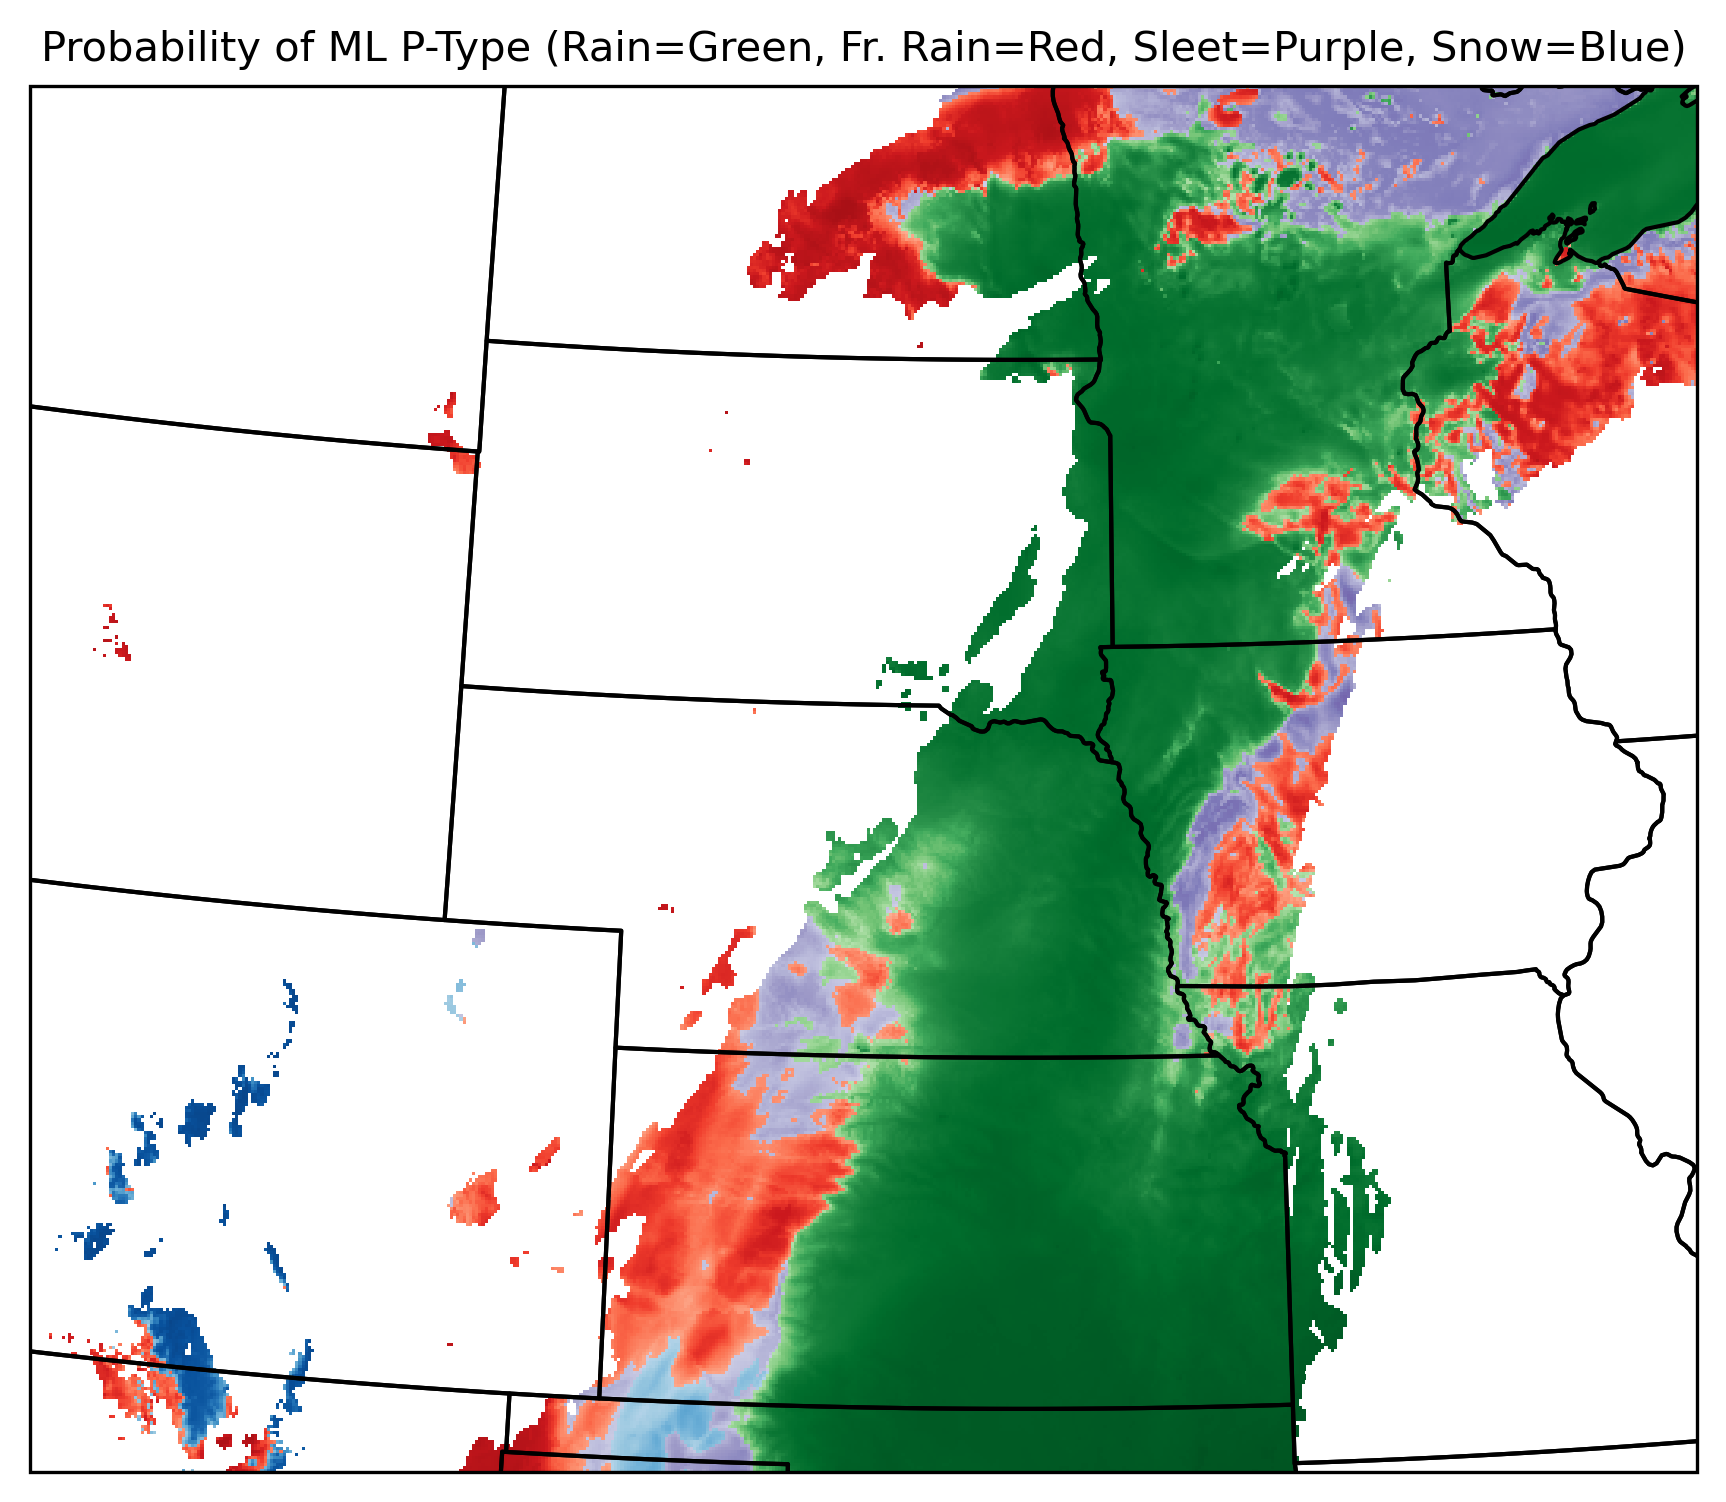

In [10]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5), 
                            globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))
                            
llp = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=lcc), dpi=300, figsize=(10, 6))
ax.add_feature(cfeature.STATES)
f = 10
valid_date = run_date + pd.Timedelta(seconds=3600 * f)
valid_date_str = valid_date.strftime('%Y-%m-%d %H UTC')
cmaps = ["Greens", "Reds", "Purples", "Blues"]
for p, ptype in enumerate(ptypes):
    print(ptype)
    ptype_mask = hrrr_all[f"ML_{ptype}"][f] * hrrr_all[f"ML_c{ptype}"][f] * precip_mask.max(axis=0)
    plt.pcolormesh(hrrr_runs[f]["longitude"], hrrr_runs[f]["latitude"], np.ma.array(ptype_mask, mask=ptype_mask==0), transform=llp, 
                   vmin=0, vmax=1, cmap=cmaps[p])
plt.title("Probability of ML P-Type (Rain=Green, Fr. Rain=Red, Sleet=Purple, Snow=Blue)", fontsize=10)
plt.savefig("four_class_prob_map.png", dpi=300, bbox_inches="tight")
    #plt.colorbar(orientation="horizontal", fraction=0.05)

/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


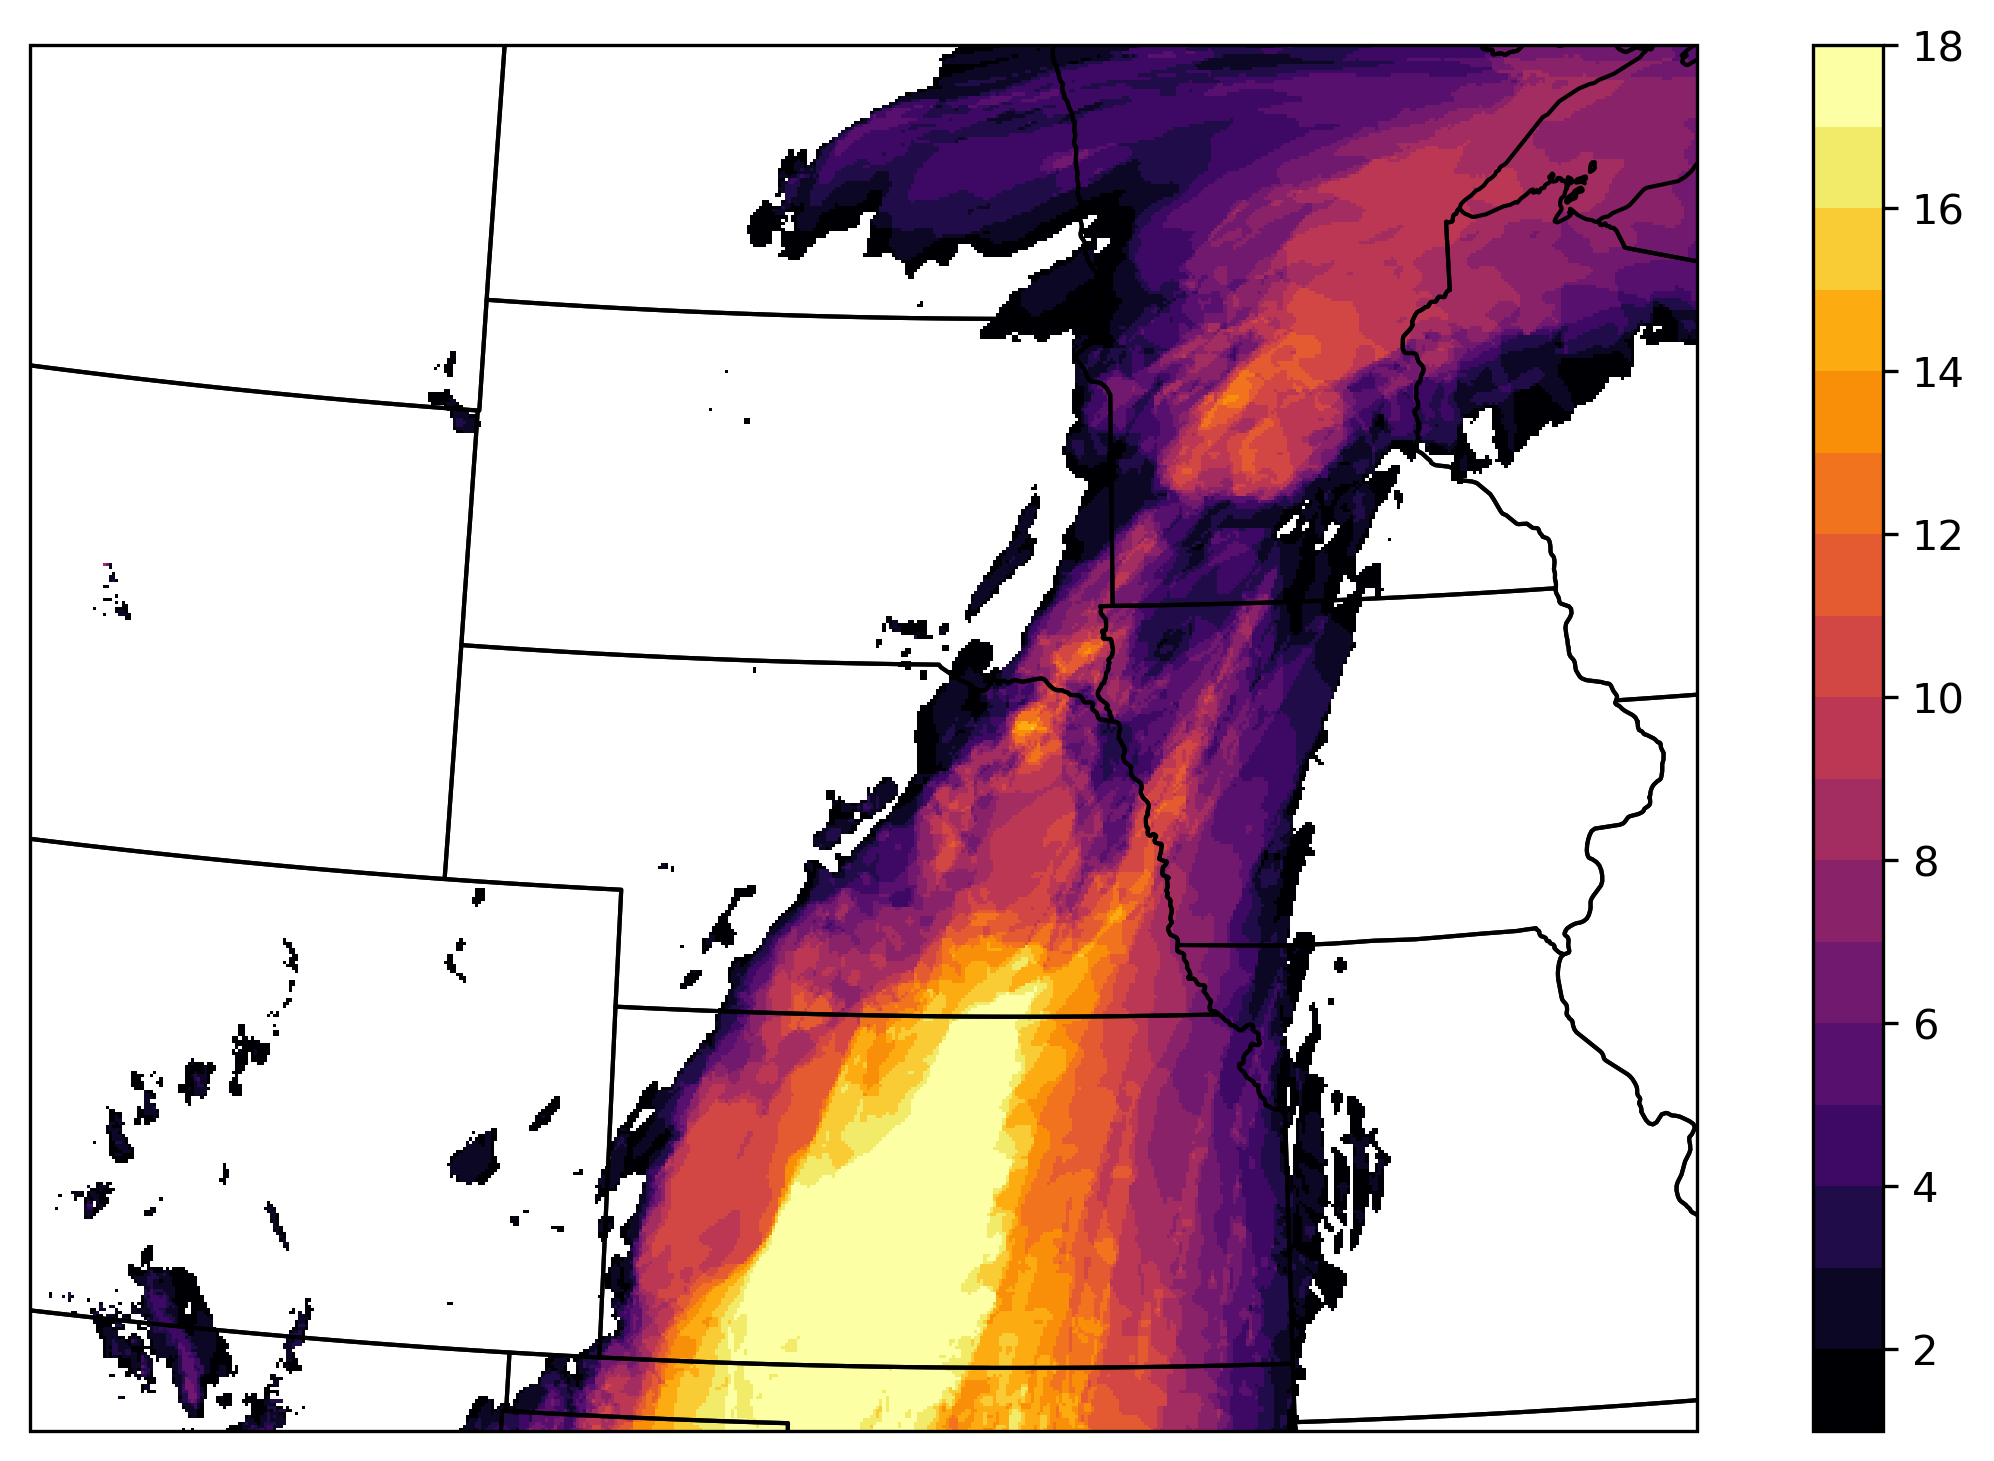

In [18]:
lcc = ccrs.LambertConformal(central_longitude=-97.5, central_latitude=38.5, standard_parallels=(38.5, 38.5), 
                            globe=ccrs.Globe(semimajor_axis=6370000, semiminor_axis=6370000))
                            
llp = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=lcc), dpi=300, figsize=(10, 6))
ax.add_feature(cfeature.STATES)
f = 5
plt.pcolormesh(hrrr_runs[f]["longitude"], hrrr_runs[f]["latitude"], np.ma.array(precip_mask.sum(axis=0), 
                                                                                mask=precip_mask.sum(axis=0)==0), 
               transform=llp, vmin=1, vmax=18, cmap=plt.get_cmap("inferno", 17))
plt.colorbar()

In [11]:
lon_p = -99.6114
lat_p = 38.8403
x_p, y_p= lcc.transform_point(lon_p, lat_p, src_crs=llp)
dist = (lon_p - (hrrr_all["longitude"].values - 360)) ** 2 + (lat_p - hrrr_all["latitude"].values) ** 2
i, j = np.unravel_index(np.argmin(dist.ravel()), hrrr_all["longitude"].shape)
norfolk_ne = hrrr_all.sel(x=j,y=i)
print(i, j)
norfolk_ne

88 253


<xarray.Dataset>
Dimensions:        (time: 18, isobaricInhPa: 40)
Coordinates:
  * time           (time) datetime64[ns] 2023-12-15 2023-12-15 ... 2023-12-15
    step           (time) timedelta64[ns] 01:00:00 02:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float32 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       float32 38.83
    longitude      float32 260.4
    valid_time     (time) datetime64[ns] 2023-12-15T01:00:00 ... 2023-12-15T1...
    atmosphere     float32 0.0
Data variables: (12/35)
    t              (time, isobaricInhPa) float32 6.078 5.417 ... -62.48 -61.06
    u              (time, isobaricInhPa) float32 -0.9956 -0.9566 ... 9.921 3.654
    v              (time, isobaricInhPa) float32 2.143 2.175 ... -5.605 -8.49
    dpt            (time, isobaricInhPa) float32 5.843 5.142 ... -81.03 -81.03
    gh             (time, isobaricInhPa) float32 129.2 218.5 ... 2.054e+04
    orog           (time) float32 682.5 682.5 682.5 682.5 ... 682.5 682.5 682.5
    ...             ...
    ML_snow        (time) float32 0.1026 0.1631 0.2004 ... 0.3942 0.3782 0.3359
    ML_csnow       (time) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
    ML_icep        (time) float32 0.3072 0.5852 0.4215 ... 0.2452 0.2065 0.2094
    ML_cicep       (time) uint8 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
    ML_frzr        (time) float32 0.1026 0.1259 0.09967 ... 0.0791 0.0769
    ML_cfrzr       (time) uint8 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-12-14T18:49 GRIB to CDM+CF via cfgrib-0.9.1...

In [51]:
norfolk_ne["ML_S"] = 4 / norfolk_ne['ML_u']
for ptype in ptypes:
    norfolk_ne[f"ML_{ptype}_alpha"] = norfolk_ne[f'ML_{ptype}'] * norfolk_ne["ML_S"]
percentiles = [0.25, 0.75]
ptype_arr = np.array(ptypes)
for ptype in ptypes:
    other_ptypes = ptype_arr[ptype_arr != ptype]
    other_alpha = xr.concat([norfolk_ne[f"ML_{ptype}_alpha"] for ptype in other_ptypes], "ptype").sum(dim="ptype")
    for percentile in percentiles:
        per_int = int(percentile * 100)
        norfolk_ne[f"ML_{ptype}_{per_int}"] = xr.DataArray(np.zeros(norfolk_ne["time"].shape), dims="time")
    for t in range(norfolk_ne["time"].shape[0]):
        per_out = beta.ppf(percentiles, norfolk_ne[f"ML_{ptype}_alpha"][t], other_alpha[t])
        for p, percentile in enumerate(percentiles):
            per_int = int(percentile * 100)
            norfolk_ne[f"ML_{ptype}_{per_int}"][t] = per_out[p]

['rain', 'frzr', 'icep', 'snow']


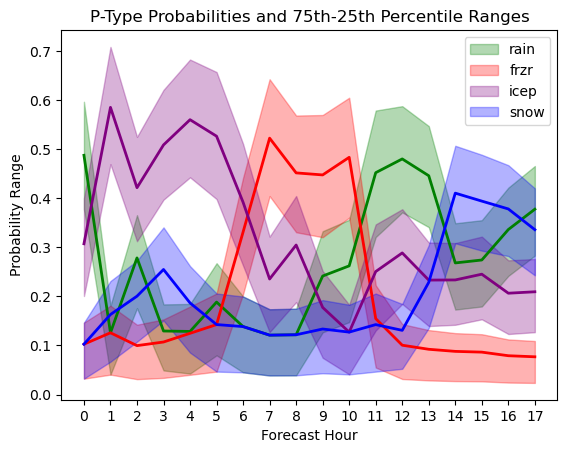

In [55]:
print(ptypes)
p_colors = ["green", "red", "purple", "blue"]
hours = np.arange(18)
for p, ptype in enumerate(ptypes):
    plt.fill_between(hours, norfolk_ne[f"ML_{ptype}_75"], norfolk_ne[f"ML_{ptype}_25"], alpha=0.3, color=p_colors[p], label=ptype)
    plt.plot(hours, norfolk_ne[f"ML_{ptype}"], color=p_colors[p], lw=2)
plt.legend()
_ = plt.xticks(hours)
plt.xlabel("Forecast Hour")
plt.ylabel("Probability Range")
plt.title("P-Type Probabilities and 75th-25th Percentile Ranges")
plt.savefig("ptype_prange.png", dpi=300, bbox_inches="tight")

In [16]:
beta.ppf([0.1, 0.9], 50, 5)

array([0.85739578, 0.95427352])

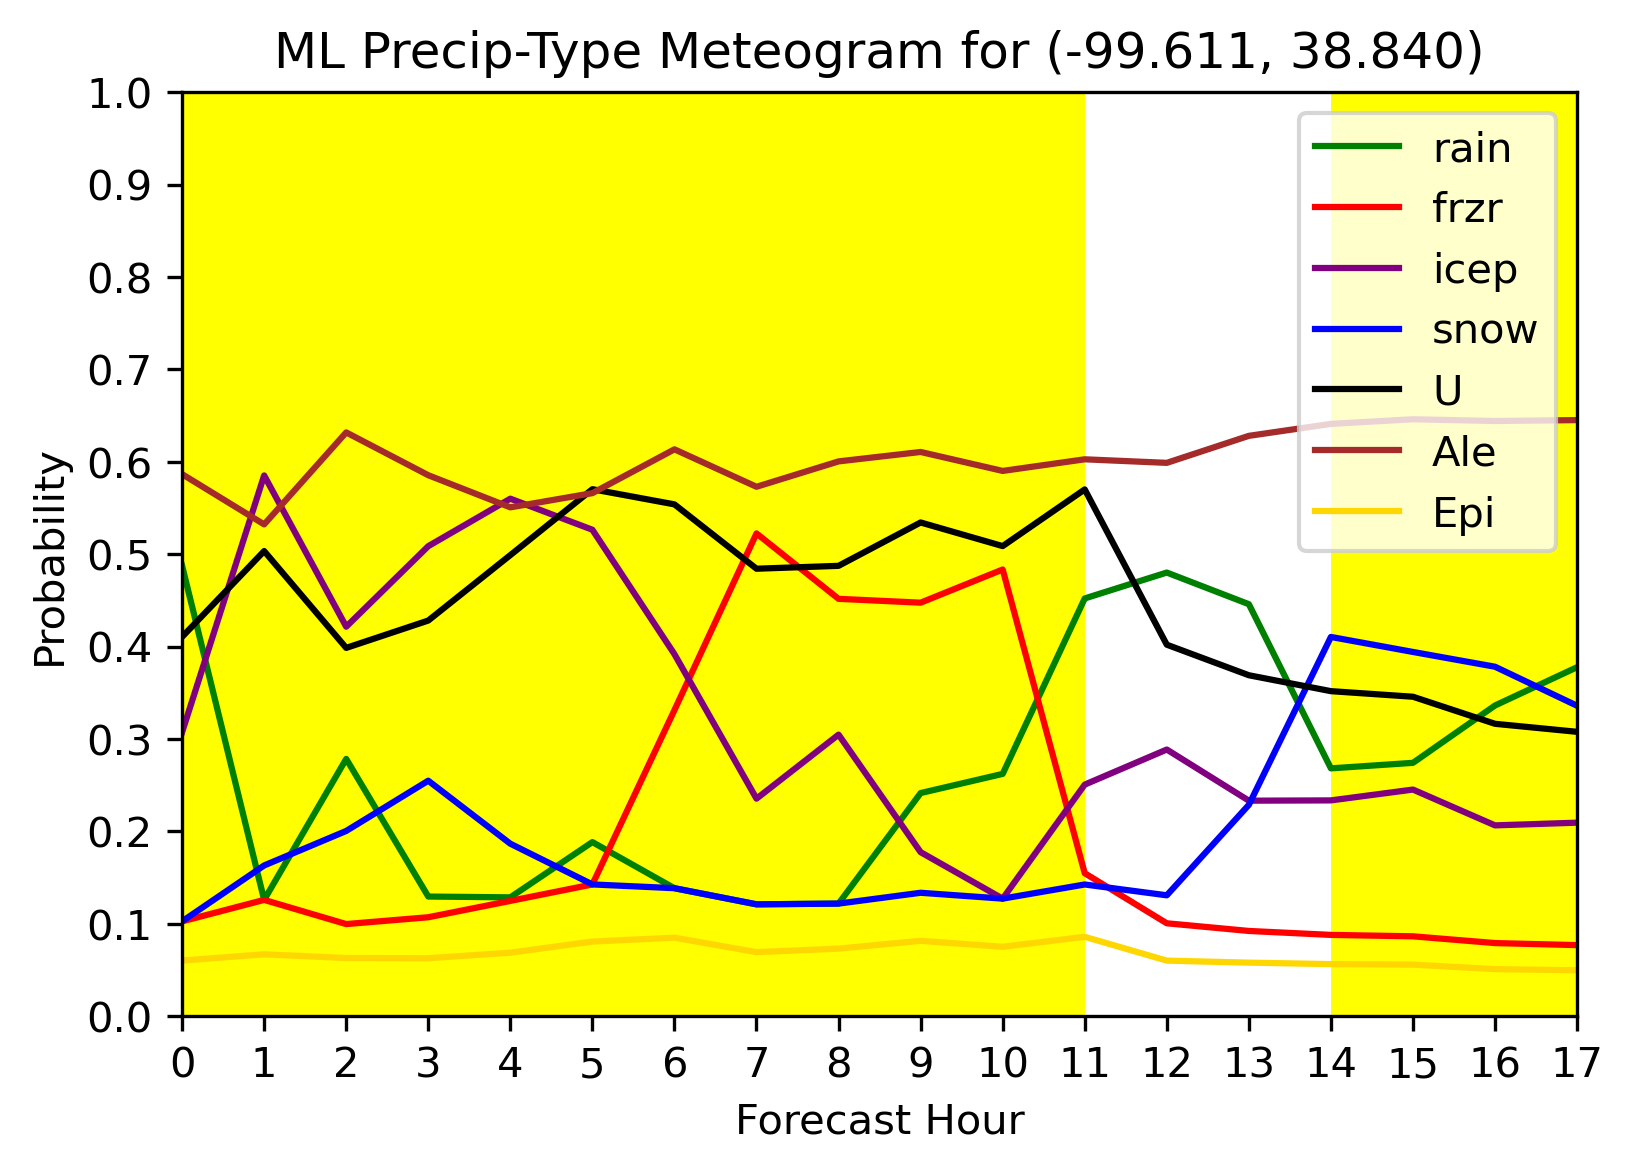

In [33]:
plt.figure(figsize=(6, 4), dpi=300)
plt.bar(np.arange(0, 18), precip_mask[:, i, j], width=1, color='yellow', align="edge")
plt.plot(norfolk_ne['ML_rain'].values, color='g', label="rain")
plt.plot(norfolk_ne['ML_frzr'].values, color='r', label="frzr")
plt.plot(norfolk_ne['ML_icep'].values, color='purple', label="icep")
plt.plot(norfolk_ne['ML_snow'].values, color='b', label="snow")
plt.plot(norfolk_ne['ML_u'].values, color='k', label="U")
plt.plot(norfolk_ne['ML_snow_ale'].values + norfolk_ne['ML_rain_ale'].values + norfolk_ne['ML_frzr_ale'].values + norfolk_ne['ML_icep_ale'].values, color='brown', label="Ale")
plt.plot(norfolk_ne['ML_snow_epi'].values + norfolk_ne['ML_rain_epi'].values + norfolk_ne['ML_frzr_epi'].values + norfolk_ne['ML_icep_epi'].values, color='gold', label="Epi")

plt.xticks(np.arange(18))
plt.xlim(0, 17)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1)
plt.xlabel("Forecast Hour")
plt.ylabel("Probability")
plt.legend()
plt.title(f"ML Precip-Type Meteogram for ({lon_p:0.3f}, {lat_p:0.3f})") 
plt.savefig("ptype_meteogram_example.png", dpi=300, bbox_inches="tight")

In [97]:
print(hrrr_all["longitude"][206, 316] - 360, hrrr_all["latitude"][206, 316])

<xarray.DataArray 'longitude' ()>
array(-97.43377686)
Coordinates:
    latitude    float32 42.03
    longitude   float32 262.6
    atmosphere  float32 0.0 <xarray.DataArray 'latitude' ()>
array(42.029175, dtype=float32)
Coordinates:
    latitude    float32 42.03
    longitude   float32 262.6
    atmosphere  float32 0.0
Attributes:
    units:          degrees_north
    standard_name:  latitude
    long_name:      latitude


In [78]:
hrrr_all["x"]

<xarray.DataArray 'x' (x: 528)>
array([  0,   1,   2, ..., 525, 526, 527])
Coordinates:
    atmosphere  float32 0.0
Dimensions without coordinates: x

In [68]:
hrrr_all

<xarray.Dataset>
Dimensions:        (time: 18, isobaricInhPa: 40, y: 439, x: 528)
Coordinates:
  * time           (time) datetime64[ns] 2023-12-12T12:00:00 ... 2023-12-12T1...
    step           (time) timedelta64[ns] 01:00:00 02:00:00 ... 18:00:00
  * isobaricInhPa  (isobaricInhPa) float32 1.013e+03 1e+03 975.0 ... 75.0 50.0
    latitude       (y, x) float32 35.99 35.99 36.0 36.0 ... 47.99 47.98 47.98
    longitude      (y, x) float32 252.0 252.0 252.1 252.1 ... 270.9 270.9 271.0
    valid_time     (time) datetime64[ns] 2023-12-12T13:00:00 ... 2023-12-13T0...
    atmosphere     float32 0.0
Dimensions without coordinates: y, x
Data variables: (12/35)
    t              (time, isobaricInhPa, y, x) float32 15.11 14.98 ... -55.56
    u              (time, isobaricInhPa, y, x) float32 -2.563 -2.563 ... 15.76
    v              (time, isobaricInhPa, y, x) float32 2.669 2.669 ... -3.906
    dpt            (time, isobaricInhPa, y, x) float32 1.124 1.687 ... -81.03
    gh             (time, isobaricInhPa, y, x) float32 39.86 40.55 ... 2.034e+04
    orog           (time, y, x) float32 1.932e+03 1.929e+03 ... 179.0 226.4
    ...             ...
    ML_snow        (time, y, x) float32 0.06573 0.06293 0.06165 ... 0.89 0.8944
    ML_csnow       (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    ML_icep        (time, y, x) float32 0.3153 0.2487 0.2271 ... 0.03668 0.03522
    ML_cicep       (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    ML_frzr        (time, y, x) float32 0.5533 0.6255 0.6497 ... 0.03668 0.03522
    ML_cfrzr       (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2023-12-12T06:48 GRIB to CDM+CF via cfgrib-0.9.1...

/glade/work/dgagne/conda-envs/risk/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1781: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


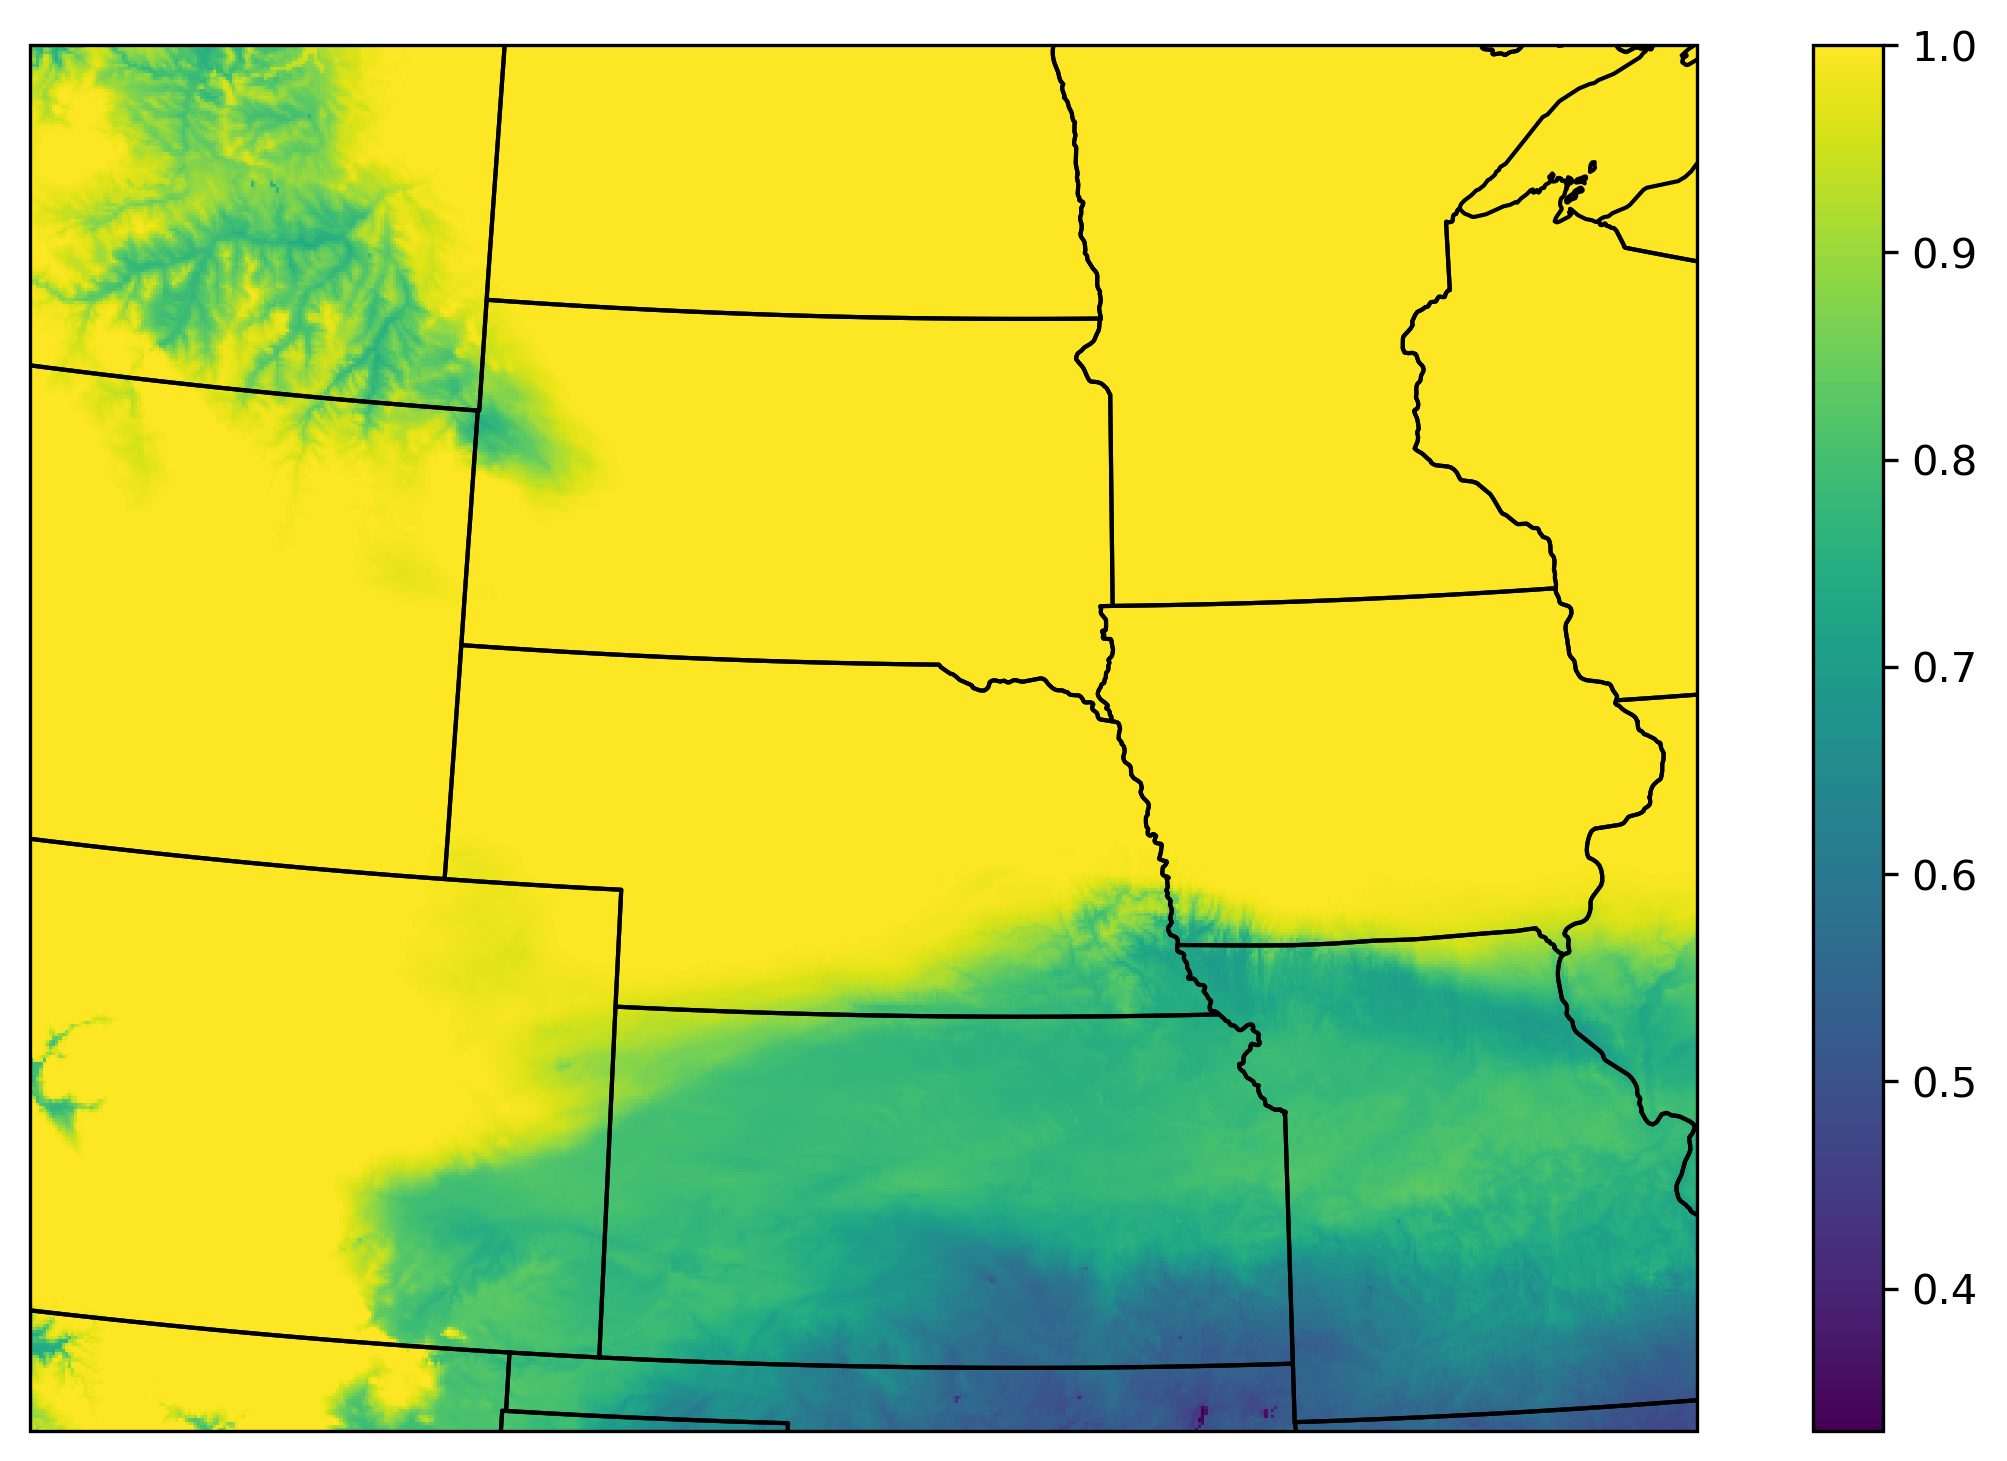

In [52]:

total_prob =  1 - np.prod(1 - hrrr_all["ML_snow"].values, axis=0)
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=lcc), dpi=300, figsize=(10, 6))
ax.add_feature(cfeature.STATES)
plt.pcolormesh(hrrr_all["longitude"], hrrr_all["latitude"], total_prob, transform=llp)
plt.colorbar()

In [47]:
total_prob

<xarray.DataArray 'ML_frzr' (y: 439, x: 528)>
array([[0.9422764 , 0.9646133 , 0.9702525 , ..., 0.88574946, 0.86946356,
        0.9295425 ],
       [0.9310059 , 0.94757247, 0.9711264 , ..., 0.8347115 , 0.66982114,
        0.8762418 ],
       [0.89945894, 0.95352393, 0.9698349 , ..., 0.85416985, 0.75618935,
        0.92387736],
       ...,
       [0.9999993 , 0.99999976, 0.9999999 , ..., 0.45985156, 0.45160204,
        0.44816518],
       [0.99999994, 1.        , 1.        , ..., 0.45998836, 0.45543247,
        0.44969577],
       [1.        , 1.        , 1.        , ..., 0.47086823, 0.47283912,
        0.45933956]], dtype=float32)
Coordinates:
    latitude    (y, x) float32 35.99 35.99 36.0 36.0 ... 47.99 47.99 47.98 47.98
    longitude   (y, x) float32 252.0 252.0 252.1 252.1 ... 270.9 270.9 271.0
    atmosphere  float32 0.0
Dimensions without coordinates: y, x

In [61]:
1 - np.exp(np.sum(np.log(1 - hrrr_all["ML_snow"][:, 200, 200])))

<xarray.DataArray 'ML_snow' ()>
array(0.99999998)
Coordinates:
    latitude    float32 41.8
    longitude   float32 258.4
    atmosphere  float32 0.0

In [64]:
np.cumprod(1 - hrrr_all["ML_snow"][:, 200, 200])

<xarray.DataArray 'ML_snow' (time: 18)>
array([3.8647461e-01, 1.0279885e-01, 1.8258341e-02, 3.1180931e-03,
       5.4810231e-04, 1.0123032e-04, 1.8937435e-05, 3.7403283e-06,
       9.4375719e-07, 2.9308086e-07, 1.3314214e-07, 8.1702332e-08,
       5.4554658e-08, 4.2384414e-08, 3.4476141e-08, 2.6692495e-08,
       2.0701998e-08, 1.5957369e-08], dtype=float32)
Coordinates:
  * time        (time) datetime64[ns] 2023-12-12T12:00:00 ... 2023-12-12T12:0...
    step        (time) timedelta64[ns] 01:00:00 02:00:00 ... 17:00:00 18:00:00
    latitude    float32 41.8
    longitude   float32 258.4
    valid_time  (time) datetime64[ns] 2023-12-12T13:00:00 ... 2023-12-13T06:0...
    atmosphere  float32 0.0